# NBA Winner Prediction Model

In [159]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, make_scorer,  confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [103]:
# Load the dataset: NBA statistics from the 2013-2014 basketball season
df_results_2020 = pd.read_csv("C:\\Users\\makar\\Final-LHL-Project\\data\\NBA_Results_19_20.csv", parse_dates = ['DATE'])

In [104]:
scorer = make_scorer(f1_score, pos_label = None, average = 'weighted')

In [105]:
# Examine the dataset with its initial formatting
df_results_2020.head()

,DATE,VISITOR,AWAY_PTS,HOME,HOME_PTS,ATTENDANCE,ARENA
0,2019-10-22,New Orleans Pelicans,122,Toronto Raptors,130,20787.0,Scotiabank Arena
1,2019-10-22,Los Angeles Lakers,102,Los Angeles Clippers,112,19068.0,STAPLES Center
2,2019-10-23,Chicago Bulls,125,Charlotte Hornets,126,15424.0,Spectrum Center
3,2019-10-23,Detroit Pistons,119,Indiana Pacers,110,17923.0,Bankers Life Fieldhouse
4,2019-10-23,Cleveland Cavaliers,85,Orlando Magic,94,18846.0,Amway Center


In [106]:
df_results_2020.shape

(1059, 7)

## Baseline Model - Home-Court Advantage 

"In basketball, the phrase “home-court advantage” typically refers to the physical and psychological benefits that a player experiences when competing in his own arena."

https://www.samford.edu/sports-analytics/fans/2019/Quantifying-the-Home-Court-Advantage-in-the-NBA-Playoffs

In [107]:
# Generate a new feature that notes whether the home team won
df_results_2020['HOME_WIN'] = df_results_2020['AWAY_PTS'] < df_results_2020['HOME_PTS']

# This will also be the value that we want to predict 
y_true = df_results_2020['HOME_WIN'].values

In [108]:
df_results_2020.isnull().sum()

DATE           0
VISITOR        0
AWAY_PTS       0
HOME           0
HOME_PTS       0
ATTENDANCE    88
ARENA          0
HOME_WIN       0
dtype: int64

In [109]:
# Baseline win percentage of Home Teams overall
n_games = df_results_2020['HOME_WIN'].count()
n_homewins = df_results_2020['HOME_WIN'].sum()
win_percentage = n_homewins / n_games

print('Home Win percentage: {0:.2f}%'.format(100 * win_percentage))

Home Win percentage: 55.15%


The home teams' win percentage is 55%. For a model to be considered robust, it must at least have a better score than the baseline model.

In [110]:
# Predicting the baseline for Home Teams wins with simple classifier
y_pred = [1] * len(y_true)
print('F1: {0:.2f}%'.format(f1_score(y_true, y_pred, pos_label = None, average = 'weighted') * 100))

F1: 39.20%


## Decision Tree Classification

### Feature Engineering - LAST_WIN

Let's add features that determine whether home and visitor teams won their last game.

In [111]:
df_results_2020['HOME_LAST_WIN'] = False
df_results_2020['VISITOR_LAST_WIN'] = False

In [112]:
from collections import defaultdict

won_last = defaultdict(int)   # The default value of int is 0

# Inefficient method to deterime previous wins
for index, row in df_results_2020.iterrows():
    home_team = row['HOME']
    away_team = row['VISITOR']
    row['HOME_LAST_WIN'] = won_last[home_team]
    row['VISITOR_LAST_WIN'] = won_last[away_team]
    df_results_2020.loc[index] = row
    # Set current win
    won_last[home_team] = row['HOME_WIN']
    won_last[away_team] = not row['HOME_WIN']

In [113]:
df_results_2020['HOME_LAST_WIN'].replace([0], False, inplace=True)
df_results_2020['VISITOR_LAST_WIN'].replace([0], False, inplace=True)

In [114]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

In [115]:
from sklearn.model_selection import cross_val_score

# Use selected features as input for the classifier (target)
X_wins = df_results_2020[['HOME_LAST_WIN', 'VISITOR_LAST_WIN']].values

# Decision Tree Classifier
scores = cross_val_score(dtc, X_wins, y_true, scoring = scorer)

# Print results
print("Using the previous results of the home and visitor teams")
print('F1: {0:.2f}%'.format(np.mean(scores) * 100))

Using the previous results of the home and visitor teams
F1: 53.93%


## Decision Tree Classification

### Feature Engineering - WIN_STREAK

Let's add features that determine whether home and visitor teams are on a winning streak.

In [116]:
# Create two columns for home and visitor win streaks
df_results_2020['HOME_WIN_STREAK'] = 0
df_results_2020['VISITOR_WIN_STREAK'] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in df_results_2020.iterrows():  
    home_team = row['HOME']
    visitor_team = row['VISITOR']
    row['HOME_WIN_STREAK'] = win_streak[home_team]
    row['VISITOR_WIN_STREAK'] = win_streak[visitor_team]
    df_results_2020.loc[index] = row    
    
    # Set current win streak
    if row['HOME_WIN']:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

In [117]:
df_results_2020.head()

,DATE,VISITOR,AWAY_PTS,HOME,HOME_PTS,ATTENDANCE,ARENA,HOME_WIN,HOME_LAST_WIN,VISITOR_LAST_WIN,HOME_WIN_STREAK,VISITOR_WIN_STREAK
0,2019-10-22,New Orleans Pelicans,122,Toronto Raptors,130,20787.0,Scotiabank Arena,True,False,False,0,0
1,2019-10-22,Los Angeles Lakers,102,Los Angeles Clippers,112,19068.0,STAPLES Center,True,False,False,0,0
2,2019-10-23,Chicago Bulls,125,Charlotte Hornets,126,15424.0,Spectrum Center,True,False,False,0,0
3,2019-10-23,Detroit Pistons,119,Indiana Pacers,110,17923.0,Bankers Life Fieldhouse,False,False,False,0,0
4,2019-10-23,Cleveland Cavaliers,85,Orlando Magic,94,18846.0,Amway Center,True,False,False,0,0


In [118]:
X_win_streak = df_results_2020[['HOME_LAST_WIN', 'VISITOR_LAST_WIN', 'HOME_WIN_STREAK', 'VISITOR_WIN_STREAK']].values

# Decision Tree Classifier
scores = cross_val_score(dtc, X_win_streak, y_true, scoring = scorer)

# Print results
print("Using whether the home team is ranked higher")
print("F1: {0:.2f}%".format(np.mean(scores) * 100))

Using whether the home team is ranked higher
F1: 49.28%


## Decision Tree Classification

### Feature Engineering - Previous Season Standings

Let's create a new feature where we determine if the home team ranks higher

In [119]:
df_standings_2019 = pd.read_excel("C:\\Users\\makar\\Final-LHL-Project\\data\\NBA_Standings_18_19.xlsx", skiprows=[0], index_col = 'Team')

In [120]:
df_standings_2019.columns = ['Rank', 'Overall', 'Home', 'Road', 'Eastern Conf', 'Western Conf', 
                'Atlantic Div', 'Central Div', 'Southeast Div', 'Northwest Div', 'Pacific Div', 'Southwest Div', 
                'Pre All-Star', 'Post All-Star', 'Margin ≤3', 'Margin ≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 
                'Mar', 'Apr']

In [121]:
df_standings_2019.head()

,Rank,Overall,Home,Road,Eastern Conf,Western Conf,Atlantic Div,Central Div,Southeast Div,Northwest Div,...,Post All-Star,Margin ≤3,Margin ≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
Team,,,,,,,,,,,,,,,,,,,,,
Milwaukee Bucks,1,60-22,33-8,27-14,40-12,20-10,13-5,14-2,13-5,6-4,...,17-8,5-6,45-5,7-0,8-6,10-4,12-3,10-1,10-6,3-2
Toronto Raptors,2,58-24,32-9,26-15,36-16,22-8,12-4,10-8,14-4,6-4,...,15-8,11-7,33-9,7-1,12-3,8-7,10-5,8-1,9-6,4-1
Golden State Warriors,3,57-25,30-11,27-14,22-8,35-17,6-4,8-2,8-2,12-6,...,16-9,7-7,34-10,8-1,7-7,10-5,11-2,7-4,9-5,5-1
Denver Nuggets,4,54-28,34-7,20-21,20-10,34-18,7-3,6-4,7-3,12-4,...,15-10,13-3,23-11,6-1,9-6,8-4,12-4,7-4,9-6,3-3
Houston Rockets,5,53-29,31-10,22-19,21-9,32-20,8-2,6-4,7-3,8-10,...,20-5,5-7,29-12,1-5,9-6,11-4,8-6,8-4,12-3,4-1


In [122]:
# Create a feature that will determine if the home team ranks higher

def home_team_ranks_higher(row):
    home_team = row['HOME']
    visitor_team = row['VISITOR']
    
    home_rank = df_standings_2019.loc[home_team]['Rank']
    visitor_rank = df_standings_2019.loc[visitor_team]['Rank']
    
    return home_rank < visitor_rank

In [123]:
# Create new column by using .apply(home_team_ranks_higher) across the DataFrame
df_results_2020["HOME_RANK_HIGHER"] = df_results_2020.apply(home_team_ranks_higher, axis = 1)
df_results_2020.head()

,DATE,VISITOR,AWAY_PTS,HOME,HOME_PTS,ATTENDANCE,ARENA,HOME_WIN,HOME_LAST_WIN,VISITOR_LAST_WIN,HOME_WIN_STREAK,VISITOR_WIN_STREAK,HOME_RANK_HIGHER
0,2019-10-22,New Orleans Pelicans,122,Toronto Raptors,130,20787.0,Scotiabank Arena,True,False,False,0,0,True
1,2019-10-22,Los Angeles Lakers,102,Los Angeles Clippers,112,19068.0,STAPLES Center,True,False,False,0,0,True
2,2019-10-23,Chicago Bulls,125,Charlotte Hornets,126,15424.0,Spectrum Center,True,False,False,0,0,True
3,2019-10-23,Detroit Pistons,119,Indiana Pacers,110,17923.0,Bankers Life Fieldhouse,False,False,False,0,0,True
4,2019-10-23,Cleveland Cavaliers,85,Orlando Magic,94,18846.0,Amway Center,True,False,False,0,0,True


In [124]:
X_home_higher = df_results_2020[['HOME_LAST_WIN', 'VISITOR_LAST_WIN', 'HOME_RANK_HIGHER']].values

# Decision Tree Classifier
scores = cross_val_score(dtc, X_home_higher, y_true, scoring = scorer)

# Print results
print("Using whether the home team is ranked higher")
print("F1: {0:.2f}%".format(np.mean(scores) * 100))

Using whether the home team is ranked higher
F1: 59.69%


## Decision Tree Classification

### Feature Engineering - Last Match Winner

Let's create a new feature where we determine whether the home team won the last encounter.

In [125]:
last_game_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row['HOME']
    visitor_team = row['VISITOR']
    
    # Sort for a consistent ordering
    teams = tuple(sorted([home_team, visitor_team]))
    # Parse the row for which team won the last matchup, then add a 1 if the Home Team won
    if last_game_winner[teams] == row['HOME']:
        result = 1 
    else:
        result = 0
    
    # Update record for next matchup
    winner = row['HOME'] if row['HOME_WIN'] else row['VISITOR']
    last_game_winner[teams] = winner
    
    return result

df_results_2020['HOME_TEAM_WON_LAST'] = df_results_2020.apply(home_team_won_last, axis=1)

In [126]:
df_results_2020.drop(['ATTENDANCE', 'ARENA'], axis=1, inplace=True)

In [127]:
df_results_2020.replace({False: 0, True: 1}, inplace=True)

In [128]:
df_results_2020.drop(['DATE'], axis=1, inplace=True)

### Feature Engineering - +/- ROLLING AVERAGE

In [129]:
df_results_2020['PLUS_MINUS'] = df_results_2020['HOME_PTS'] - df_results_2020['AWAY_PTS']

In [130]:
df_results_2020.drop(['AWAY_PTS', 'HOME_PTS'], axis=1, inplace=True)

In [131]:
df_results_2020 = df_results_2020[['VISITOR', 'HOME', 'HOME_WIN', 'PLUS_MINUS', 'HOME_LAST_WIN', 'VISITOR_LAST_WIN', 'HOME_WIN_STREAK', 'VISITOR_WIN_STREAK', 'HOME_RANK_HIGHER', 'HOME_TEAM_WON_LAST']]

In [132]:
df_results_2020.head()

,VISITOR,HOME,HOME_WIN,PLUS_MINUS,HOME_LAST_WIN,VISITOR_LAST_WIN,HOME_WIN_STREAK,VISITOR_WIN_STREAK,HOME_RANK_HIGHER,HOME_TEAM_WON_LAST
0,New Orleans Pelicans,Toronto Raptors,1,8,0,0,0,0,1,0
1,Los Angeles Lakers,Los Angeles Clippers,1,10,0,0,0,0,1,0
2,Chicago Bulls,Charlotte Hornets,1,1,0,0,0,0,1,0
3,Detroit Pistons,Indiana Pacers,0,-9,0,0,0,0,1,0
4,Cleveland Cavaliers,Orlando Magic,1,9,0,0,0,0,1,0


In [133]:
X_plus_minus = df_results_2020[['HOME_LAST_WIN', 'VISITOR_LAST_WIN', 'HOME_RANK_HIGHER', 'HOME_TEAM_WON_LAST']].values

# Decision Tree Classifier
scores = cross_val_score(dtc, X_plus_minus, y_true, scoring = scorer)

# Print results
print("Using whether the home team is ranked higher")
print("F1: {0:.2f}%".format(np.mean(scores) * 100))

Using whether the home team is ranked higher
F1: 59.59%


### Feature Engineering - OHE TEAM NAMES

In [134]:
# Use LabelEncoder to transform the teams by assigning numbers to them
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encoding = LabelEncoder()
encoding.fit(df_results_2020['HOME'].values)

LabelEncoder()

In [135]:
# Numerical values assigned to the home and visitor teams
home_teams = encoding.transform(df_results_2020['HOME'].values)
visitor_teams = encoding.transform(df_results_2020['VISITOR'].values)

# Stacks arrays in a sequence vertically & transposes the data
X_teams = np.vstack([home_teams, visitor_teams]).T

In [136]:
# OneHotEncoder
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).todense()

In [137]:
dtc = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(dtc, X_teams, y_true, scoring = scorer)

# Print results
print("F1: {0:.4f}%".format(np.mean(scores) * 100))

F1: 57.8201%


## Random Forest Classifier: Hyperparameters Tuning

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameter_space = {
                   "max_features": [2, 10, 50, 'auto'],
                   "n_estimators": [50, 100, 200],
                   "criterion": ["gini", "entropy"],
                   "min_samples_leaf": [1, 2, 4, 6],
                   }

# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 14)
grid = GridSearchCV(rfc, parameter_space, scoring = scorer)
grid.fit(X_teams, y_true)

# Print results
print("F1: {0:.4f}%".format(grid.best_score_ * 100))
print(grid.best_estimator_)

F1: 64.7298%
RandomForestClassifier(max_features=2, min_samples_leaf=2, n_estimators=50,
                       random_state=14)


## Test on 2020-2021 Season

In [139]:
df_results_2021 = pd.read_csv('C:\\Users\\makar\\Final-LHL-Project\\data\\NBA_Results_20_21.csv', parse_dates = ['DATE'])
df_results_2021.head()

,DATE,VISITOR,AWAY_PTS,HOME,HOME_PTS,ATTENDANCE,ARENA
0,2020-12-22,Golden State Warriors,99,Brooklyn Nets,125,0.0,Barclays Center
1,2020-12-22,Los Angeles Clippers,116,Los Angeles Lakers,109,0.0,STAPLES Center
2,2020-12-23,Charlotte Hornets,114,Cleveland Cavaliers,121,300.0,Rocket Mortgage Fieldhouse
3,2020-12-23,New York Knicks,107,Indiana Pacers,121,0.0,Bankers Life Fieldhouse
4,2020-12-23,Miami Heat,107,Orlando Magic,113,3396.0,Amway Center


In [140]:
df_results_2021.dtypes

DATE          datetime64[ns]
VISITOR               object
AWAY_PTS               int64
HOME                  object
HOME_PTS               int64
ATTENDANCE           float64
ARENA                 object
dtype: object

In [141]:
df_results_2021.shape

(1080, 7)

In [142]:
df_results_2021['HOME_WIN'] = df_results_2021['AWAY_PTS'] < df_results_2021['HOME_PTS']
y_test = df_results_2021['HOME_WIN'].values

In [143]:
df_standings_2020 = pd.read_excel("C:\\Users\\makar\\Final-LHL-Project\\data\\NBA_Standings_19_20.xlsx", skiprows=[0], index_col = 'Team')

In [144]:
df_standings_2020.columns = ['Rank', 'Overall', 'Home', 'Road', 'Eastern Conf', 'Western Conf', 
                'Atlantic Div', 'Central Div', 'Southeast Div', 'Northwest Div', 'Pacific Div', 'Southwest Div', 
                'Pre All-Star', 'Post All-Star', 'Margin ≤3', 'Margin ≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 
                'Mar', 'Jul', 'Aug']

## Add Features 
### Home Last Win & Visitor Last Win

In [145]:
df_results_2021['HOME_LAST_WIN'] = False
df_results_2021['VISITOR_LAST_WIN'] = False

from collections import defaultdict

won_last = defaultdict(int)

for index, row in df_results_2021.iterrows():
    home_team = row['HOME']
    away_team = row['VISITOR']
    row['HOME_LAST_WIN'] = won_last[home_team]
    row['VISITOR_LAST_WIN'] = won_last[away_team]
    df_results_2021.loc[index] = row
    # Set current win
    won_last[home_team] = row['HOME_WIN']
    won_last[away_team] = not row['HOME_WIN']

### Home Win Streak & Visitor Win Streak

In [146]:
# Create two columns for home and visitor win streaks
df_results_2021['HOME_WIN_STREAK'] = 0
df_results_2021['VISITOR_WIN_STREAK'] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in df_results_2021.iterrows():  
    home_team = row['HOME']
    visitor_team = row['VISITOR']
    row['HOME_WIN_STREAK'] = win_streak[home_team]
    row['VISITOR_WIN_STREAK'] = win_streak[visitor_team]
    df_results_2021.loc[index] = row    
    
    # Set current win streak
    if row['HOME_WIN']:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

### Home Team Ranks Higher

In [147]:
df_results_2021['HOME_RANK_HIGHER'] = df_results_2021.apply(home_team_ranks_higher, axis = 1)

### Home Team Won Last

In [148]:
df_results_2021['HOME_TEAM_WON_LAST'] = df_results_2021.apply(home_team_won_last, axis=1)

### Encode Team Names

In [149]:
encoding.fit(df_results_2021['HOME'].values)

LabelEncoder()

In [150]:
home_teams_21 = encoding.transform(df_results_2021['HOME'].values)
visitor_teams_21 = encoding.transform(df_results_2021['VISITOR'].values)

X_teams_21 = np.vstack([home_teams_21, visitor_teams_21]).T
X_teams_21 = onehot.transform(X_teams_21).todense()

In [151]:
X_home_higher_21 = df_results_2021[['HOME_LAST_WIN', 'VISITOR_LAST_WIN', 'HOME_RANK_HIGHER', 'HOME_TEAM_WON_LAST']].values

In [152]:
X_all_21 = np.hstack([X_home_higher_21, X_teams_21])
X_all_21.shape

(1080, 64)

## Baseline Model

In [153]:
print('The home team wins {:.2f}% of the games'.format(100 * np.mean(y_test)))

y_pred = [1] * len(y_test)

print('F1: {:.4f}'.format(f1_score(y_test, y_pred, pos_label = None, average = 'weighted')))
print(classification_report(y_test, y_pred))

The home team wins 54.35% of the games
F1: 0.3828
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.54      1.00      0.70       587

    accuracy                           0.54      1080
   macro avg       0.27      0.50      0.35      1080
weighted avg       0.30      0.54      0.38      1080



In [154]:
grid.fit(X_all_21, y_test)

GridSearchCV(estimator=RandomForestClassifier(random_state=14),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [2, 10, 50, 'auto'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score, pos_label=None, average=weighted))

In [155]:
y_pred = grid.predict(X_all_21)

In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.69      0.71       493
        True       0.75      0.79      0.77       587

    accuracy                           0.74      1080
   macro avg       0.74      0.74      0.74      1080
weighted avg       0.74      0.74      0.74      1080



In [157]:
print('This results in getting {:.1f}% of predictions correct.'.format(100 * np.mean(y_pred == y_test)))

This results in getting 74.1% of predictions correct.


In [163]:
import itertools

In [164]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(visible=False)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%d\n%.2f%%' % (cm[i, j], cm_norm[i, j]*100),
                 horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

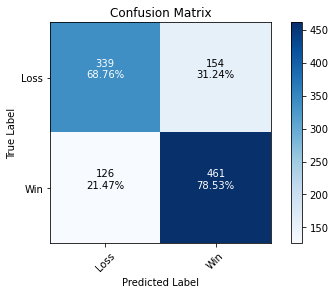

In [165]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['Loss', 'Win'])